# Pupil and SART Processor
This notebook takes the SART eye tracking .tsv from the Waking States and Memory Study and processes it to produce a file with SART performance data as well as pupil data for each trial (ie each stimulus presentation)  
  
**Requirements**: SART .tsv in the participant's folder, named according to documentation (eg 01SAI.tsv for participant *1*, *S*ART sequence *A* and *I*celandic word pairs for the memory task)  
**Input**: .tsv mentioned above  
**Output**: .csv (if export=True) with processed and analyzed pupil data as well as SART performance data for each stimulus trial

In [32]:
#for retreiving the correct data file
import glob

# for data structures and tools
import numpy as np
import pandas as pd

#for plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

#for some analyses

from scipy import stats
from scipy.signal import butter, filtfilt, freqz

# for interactive plots
import plotly.tools as pt
pt.set_credentials_file(********)
import plotly.plotly as py
import cufflinks as cf
import plotly.graph_objs as go

## Initial Editable Parameters
Edit these variables before processing each file  
 -**participant_num**: an integer, the participant number whose files you are going to process   
 -**sart_sequence**: a string ('A' or 'B'), for which sart file of the participant  
 -**view_graph**: boolean, if True, an overview of the eye data will be shown for you to look at  
 -**export**: boolean, if True, the final processed file will be saved (probably what you want)

In [33]:
participant_num = 2
sart_sequence = 'B'
view_graph = True
export = True

In [34]:
# These are the values coded for events
start_val = '100'
end_val = '101'
stim_val = '20'
block_val = '30'
break_val = '40'
probe_vals_int = [i for i in range(6)]
probe_vals_str = [str(i) for i in probe_vals_int]

pathdict = {'pNum': participant_num, 'seq': sart_sequence}
base_path = 'X:/PROJECTS/14. Waking States and Memory/Data/'

# Create a dataframe containing the correct sequence of events
correct_seq = pd.DataFrame.from_csv(path= base_path + 'correct_seq.csv')

# This is the path of the event sart file to be analyzed
participant_path = base_path + '%(pNum)02d' % pathdict
tsv_path = glob.glob(participant_path + '/%(pNum)02dS%(seq)s[SI].tsv' % pathdict)[0]
print('ANALYZING FILE: ' + tsv_path)

ANALYZING FILE: X:/PROJECTS/14. Waking States and Memory/Data/02\02SBI.tsv


## Functions for Processing

In [35]:
# Change_threshold determines how much psize should 
CHANGE_THRESHOLD= 1
# QTHRESHOLD determines what percentage of the surrounding samples must be below the change threshold
QTHRESHOLD = 0.8
# WINDOW determines how many surrounding samples (including itself) are used to calculate a points average
WINDOW = 9
# TRIALS_COUNT is the number of stimulus trials in the entire experiment
TRIALS_COUNT = 324

def checkEvents(series, seq):
    # This function checks if the events in the participant file are all present and in the correct order.
    # If there its correct, it will print out a confirmation, otherwise it will raise an error
    # 
    # Arguments
    # series: should be a series of events (stimulus, block, start, and stop) - not the probe values!
    # seq: which SART sequence it is, either 'A' or 'B'
    
    if seq not in ['A', 'B']:
        raise Exception("Incorrect seq argument, must be 'A' or 'B'")
    
    if seq == 'A':
        correctColumn = 'seqA'
    else:
        correctColumn = 'seqB'
    
    # Check for missing events by comparing each row of the event_df to the correct_seq
    block_location = 0
    for i in range(len(correct_seq)):
        try: event_df_cell = int(series.iloc[i,])
        except KeyError:
            raise Exception("File is missing events starting at index %d" %i)
        if event_df_cell == correct_seq.get_value(i, correctColumn):
            if correct_seq.get_value(i, correctColumn) == block_val:
                block_location += 1
            continue
        else:
            print("Missing event at index %d, in block %d" %(i, block_location))
            print("Current file shows %s when it should be %s." %(series.iloc[i,], correct_seq.get_value(i, correctColumn)))
            print(series.iloc[i-3:i+3])
            print(correct_seq.loc[i-3:i+3])
            raise Exception('See above...')

    print(bordered('The file has the correct sequence of events!'))

def qualityChecker(series):
    # This function takes a series of raw pupil data and returns the quality score for each sample.
    # To calculate the quality score, the series is filtered, then the discrete difference is calculated. Each sample is
    # marked  good (1) if the diff is < the CHANGE_THRESHOLD, and bad (0) if its >= it or if the original sample was a 0.
    # Lastly, a moving average is calculated and np.nan's are appended to make it the same length as the original data
    #
    # Arguments
    # series: a series of raw pupil data (left or right)
    
    original_len = len(series)
    
    processed = myFilter(series)
    processed = np.absolute(np.diff(processed))
    
    #add a NaN to the end of "processed" to make it the same length as the original series (it is shortened when doing np.diff)
    processed = np.append(processed, np.nan)
    
    processed = [0 if diff >= CHANGE_THRESHOLD or original_val == 0 else 1 for diff, original_val in zip(processed, series)]
    
    #Calculate the moving average so that quality of a sample is also defined by its surrounding points.
    if WINDOW%2 == 0:
        raise "ERROR: Window must be odd"
    pendNumber = int((WINDOW-1)/2)
    processed = np.convolve(processed, np.ones((WINDOW,))/WINDOW, mode='valid')
    processed = np.append([np.nan]*pendNumber, np.append(processed, [np.nan]*pendNumber))
    
    return processed
    
    
def myFilter(series):
    # Function applies a linear filter fowards and backwards. np.nan's will be replaced with median values so it can
    # work properly.
    #
    # Arguments
    # series: a series which you want to filter.
    
    #
    series = [series.median() if np.isnan(val) else val for val in series]
    
    # Determine the cutoff frequency between 0 and 1,
    # where 1 corresponds to the Nyquist rate...
    Wn = 0.66
    b, a = butter(10, Wn, analog=False)
    series = filtfilt(b, a, series)
    
    return series

def psizeMerger(row):
    
    #if both signals good-> average
    #if only one good-> use that one's value
    #if neither good-> nan (to be interpolated)
    if row['lquality'] >= QTHRESHOLD and row['rquality'] >= QTHRESHOLD:
        return (row['lpsize'] + row['rpsize'])/2
    elif row['lquality'] >= QTHRESHOLD:
        return row['lpsize']
    elif row['rquality'] >= QTHRESHOLD:
        return row['rpsize']
    else:
        return np.nan

def trialCalc(eyeData, stimIndices, trialFun, trialDuration=30, trialBuffer=6, beforeStim=True):
    #eyeData: a series of eye data...
    #stimIndices: a list of the indices where stimulus events occur
    #trialFun: a function to be applied to the trial
    #trialDuration: number of samples a trial should last
    #trialBuffer: number of samples spaced between the stimulus and the analysed window
    #beforeStim: whether you want to analyze the time before or after the stimulus (True: before stimulus, False: after stimulus)
    
    #check that there are the correct number of stimuli
    if len(stimIndices) != TRIALS_COUNT:
        raise Exception("Incorrect number of stimuli!")
    
    if trialDuration <= 0:
        raise Exception("trialDuration must a be positive integer!")
    
    #Apply the function to every trial window before or after stim
    if beforeStim:
        return [trialFun(eyeData.loc[idx-(trialDuration+trialBuffer):idx-trialBuffer,]) for idx in stimIndices]
    else:
        return [trialFun(eyeData.loc[idx+trialBuffer:idx+(trialDuration+trialBuffer),]) for idx in stimIndices]


def linRegSlope(series):
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(len(series)), series)
    
    return slope

def percentGoodSamples(series):
    # Returns the percent of samples greater than or equal to the quality threshold
    #
    # Arguments
    # series: a series of quality values calculated by the qualityChecker function
    numGood = sum(i >= QTHRESHOLD for i in series)
    return numGood/len(series)

def bordered(text):
    # Just makes text look pretty by placing it in a box...
    
    lines = text.splitlines()
    width = max(len(s) for s in lines)
    res = ['┌' + '─' * width + '┐']
    for s in lines:
        res.append('│' + (s + ' ' * width)[:width] + '│')
    res.append('└' + '─' * width + '┘')
    return '\n'.join(res)

# Read Data and Prepare for Processing

In [36]:
# Open the eyetracking tsv file
# Ignore the warning that the program gives
raw_df = pd.DataFrame.from_csv(tsv_path, index_col=None, sep="\t")

C:\Users\ewamsley\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



In [37]:
# Unfortunately, some of the columns of the eyetracking file have both strings and ints in them, making them a mixed type column
# This can be seen in the printed output below, which prints the column name, and the the data type
# All columns up to rawy are mixed.
for column in raw_df.columns:
    print(column, raw_df[column].dtype)

timestamp object
time object
fix object
state object
rawx object
rawy object
avgx float64
avgy float64
psize float64
Lrawx float64
Lrawy float64
Lavgx float64
Lavgy float64
Lpsize float64
Lpupilx float64
Lpupily float64
Rrawx float64
Rrawy float64
Ravgx float64
Ravgy float64
Rpsize float64
Rpupilx float64
Rpupily float64


In [38]:
# Extract and reformat the rows which log event info
trial_df = raw_df.loc[raw_df['timestamp'] == 'MSG'].copy()
trial_df['state'] = trial_df['state'].apply(str)
trial_df.drop(['timestamp',
               'fix',
               'psize',
               'Lrawx',
               'Lrawy',
               'Lavgx',
               'Lavgy',
               'Lpsize',
               'Lpupilx',
               'Lpupily',
               'Rrawx',
               'Rrawy',
               'Ravgx',
               'Ravgy',
               'Rpsize',
               'Rpupilx',
               'Rpupily'], axis=1, inplace=True)

trial_df = trial_df.rename(columns = {'index': 'stimulusIdx', 
                                      'state': 'probeResp', 
                                      'rawx': 'rt', 
                                      'rawy': 'stimType', 
                                      'avgx': 'correct',
                                      'avgy': 'logDelay'})

# get the location in df where the eye tracking begins and ends
raw_start_idx = trial_df.loc[trial_df['probeResp'] == start_val].index[0]
raw_stop_idx = trial_df.loc[trial_df['probeResp'] == end_val].index[0]
# include only the rows between the start and stop
trial_df = trial_df.loc[raw_start_idx:raw_stop_idx,]

# Check that the sequence of events is correct...
checkEvents(trial_df.loc[~trial_df['probeResp'].isin(probe_vals_int + probe_vals_str), 'probeResp'], seq=sart_sequence)

# Theres an accident in the design of the SART program where an extra
# stimulus and an extra block code were added right before the end event
# We remove those rows below
trial_df.drop(trial_df.iloc[-3:-1,].index, inplace=True)

# fix data types of the columns
trial_df['time'] = pd.datetools.to_datetime(trial_df['time'])
trial_df['probeResp'] = trial_df['probeResp'].astype(str)
trial_df['rt'] = trial_df['rt'].astype(float)
trial_df['stimType'] = trial_df['stimType'].fillna('')
trial_df['stimType'] = trial_df['stimType'].astype(str)
trial_df['correct'] = trial_df['correct'].astype(float)

# Get indices of stimulus events relative to the original, raw data frame
stim_indices = trial_df.loc[trial_df['probeResp'] == stim_val].index.tolist()

# Get indices of the break events (first = break start, second = break end). This is used later for zscoring
break_start_idx = trial_df.loc[trial_df['probeResp'] == break_val,].index[0]
break_end_idx = trial_df.loc[trial_df['probeResp'] == break_val,].index[1]

# Get rid of everything that is not a stimulus trial (block_val, start_val, break_val, etc)
trial_df = trial_df.loc[trial_df['probeResp'].isin(probe_vals_str)]

# Add the raw index of the stimuli as a new column.
try:
    trial_df['raw_index'] = stim_indices
except ValueError:
    print("ERROR: There is a mismatch between the number of stimuli events and stimuli data...")

print(bordered('Below is the current trial dataframe:'))
trial_df

┌────────────────────────────────────────────┐
│The file has the correct sequence of events!│
└────────────────────────────────────────────┘
┌─────────────────────────────────────┐
│Below is the current trial dataframe:│
└─────────────────────────────────────┘


,time,probeResp,rt,stimType,correct,logDelay,raw_index
387,2017-07-05 14:13:55.272,0,590.0,nonTarget,1.0,135.0,233
559,2017-07-05 14:14:00.908,0,387.0,nonTarget,1.0,142.0,405
727,2017-07-05 14:14:06.524,0,357.0,nonTarget,1.0,132.0,575
895,2017-07-05 14:14:12.258,0,336.0,nonTarget,1.0,146.0,742
1065,2017-07-05 14:14:17.911,0,365.0,nonTarget,1.0,161.0,912
1235,2017-07-05 14:14:23.534,0,301.0,target,0.0,122.0,1081
1405,2017-07-05 14:14:29.151,0,311.0,nonTarget,1.0,125.0,1251
1572,2017-07-05 14:14:34.765,0,422.0,nonTarget,1.0,126.0,1421
1744,2017-07-05 14:14:40.458,0,350.0,nonTarget,1.0,137.0,1590
1914,2017-07-05 14:14:46.910,0,419.0,target,0.0,127.0,1760


# Process Pupil Data

## Prepare pupil data
1. Calculate the quality of the raw pupil size for left and right eye
2. Merge the two signals according to their quality
3. Interpolate and filter the merged signal

In [39]:
# create dataframe for psize values and calculate the quality of each raw recording
rpsize = raw_df.loc[raw_df.loc[:, 'timestamp'] != 'MSG', 'Rpsize']
lpsize = raw_df.loc[raw_df.loc[:, 'timestamp'] != 'MSG', 'Lpsize']
rawx = raw_df.loc[raw_df.loc[:, 'timestamp'] != 'MSG', 'rawx'].apply(pd.to_numeric)
rawy = raw_df.loc[raw_df.loc[:, 'timestamp'] != 'MSG', 'rawy'].apply(pd.to_numeric)

psize_df = pd.DataFrame({'rpsize': rpsize, 'lpsize': lpsize, 'rawx': rawx, 'rawy': rawy})

psize_df['lquality'] = qualityChecker(lpsize)
psize_df['rquality'] = qualityChecker(rpsize)

# Next we will determine whether to use the left or right eye data for the analyses. We will choose the data that has the
# most 'good' samples
left_good_count = psize_df.loc[psize_df['lquality'] >= .8].size
right_good_count = psize_df.loc[psize_df['rquality'] >= .8].size

if left_good_count >= right_good_count:
    quality_col = 'lquality'
    psize_df['onePsize'] = psize_df['lpsize'].copy()
else:
    quality_col = 'rquality'
    psize_df['onePsize'] = psize_df['rpsize'].copy()

print(bordered('All Good!'))

┌─────────┐
│All Good!│
└─────────┘


In [40]:
# Replace all low quality samples with np.nans. This is done so we can interpolate (replace) them
psize_df.loc[psize_df[quality_col] < .8, 'onePsize'] = np.nan

# Interpolate all of the bad samples
psize_df['interpOne'] = psize_df['onePsize'].interpolate(method='linear')

# Filter the interpolated data 
psize_df['filtPsize'] = myFilter(psize_df['interpOne'])

print(bordered('All Good!'))

┌─────────┐
│All Good!│
└─────────┘


## Calculate averages and other values for each trial
Now we want to determine mean pupil size, the gaze position, and other variables for each separate trial (stimulus presentation)

In [41]:
# Now that we have the interpolated and filtered pupil size, we want to zscore it
# BUT we want to do the first half (before the break) and the second half (after the break) separately.
# The index of the start and stop of the break were extracted earlier when initially constructing the trial_df
psize_df.loc[:break_start_idx, 'zPsize'] = stats.zscore(psize_df.loc[:break_start_idx, 'filtPsize'])
psize_df.loc[break_end_idx:, 'zPsize'] = stats.zscore(psize_df.loc[break_end_idx:, 'filtPsize'])

print(bordered('All Good!'))

┌─────────┐
│All Good!│
└─────────┘


In [42]:
# Calculate the mean zscored pupil size
trial_df['baselineZMean'] = trialCalc(psize_df['zPsize'], stim_indices, np.mean)

# Calculate the mean X and Y gaze position
trial_df['gazeXMean'] = trialCalc(psize_df['rawx'], stim_indices, np.mean)
trial_df['gazeYMean'] = trialCalc(psize_df['rawy'], stim_indices, np.mean)

# Calculate the percent of samples above the quality threshold for each trial
trial_df['qualityPsize'] = trialCalc(psize_df[quality_col], stim_indices, percentGoodSamples)

print(bordered('All Good!'))
print(bordered('Below is the current trial dataframe:'))
trial_df

┌─────────┐
│All Good!│
└─────────┘
┌─────────────────────────────────────┐
│Below is the current trial dataframe:│
└─────────────────────────────────────┘


,time,probeResp,rt,stimType,correct,logDelay,raw_index,baselineZMean,gazeXMean,gazeYMean,qualityPsize
387,2017-07-05 14:13:55.272,0,590.0,nonTarget,1.0,135.0,233,2.514630,518.187794,383.897523,1.000000
559,2017-07-05 14:14:00.908,0,387.0,nonTarget,1.0,142.0,405,2.030118,517.530863,376.995817,0.633333
727,2017-07-05 14:14:06.524,0,357.0,nonTarget,1.0,132.0,575,0.834766,266.805367,244.342363,0.400000
895,2017-07-05 14:14:12.258,0,336.0,nonTarget,1.0,146.0,742,0.997437,517.092863,397.058620,1.000000
1065,2017-07-05 14:14:17.911,0,365.0,nonTarget,1.0,161.0,912,1.327249,524.624750,388.430877,1.000000
1235,2017-07-05 14:14:23.534,0,301.0,target,0.0,122.0,1081,0.020887,522.542523,378.664597,1.000000
1405,2017-07-05 14:14:29.151,0,311.0,nonTarget,1.0,125.0,1251,0.851379,527.105360,387.885490,1.000000
1572,2017-07-05 14:14:34.765,0,422.0,nonTarget,1.0,126.0,1421,0.030123,521.820247,368.491883,1.000000
1744,2017-07-05 14:14:40.458,0,350.0,nonTarget,1.0,137.0,1590,0.336404,537.603137,378.715273,1.000000
1914,2017-07-05 14:14:46.910,0,419.0,target,0.0,127.0,1760,0.106015,530.794527,390.125860,1.000000


┌───────────────────────────────────────────────────────────────────────────────────────────┐
│Red: zPsize, Blue: sample quality, Purple: stimulus onset (height equals the trial quality)│
└───────────────────────────────────────────────────────────────────────────────────────────┘


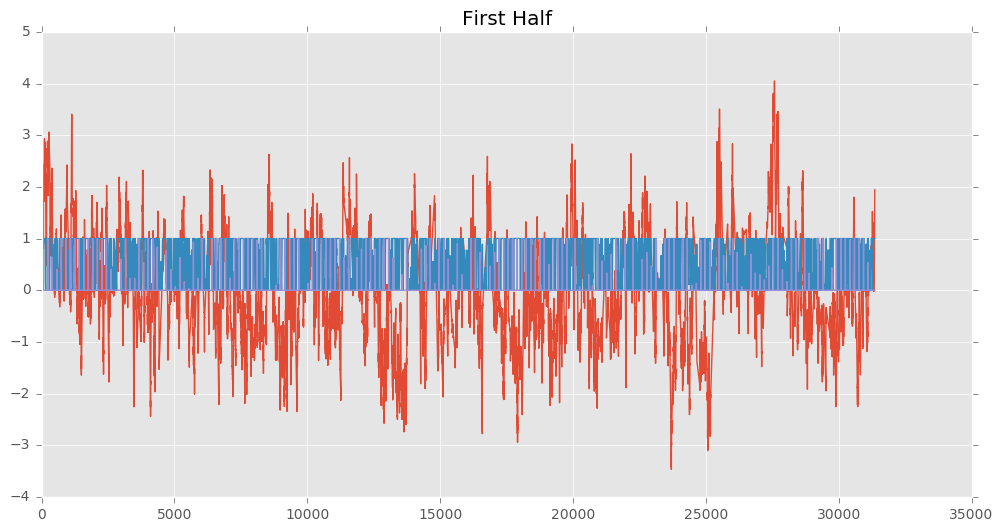

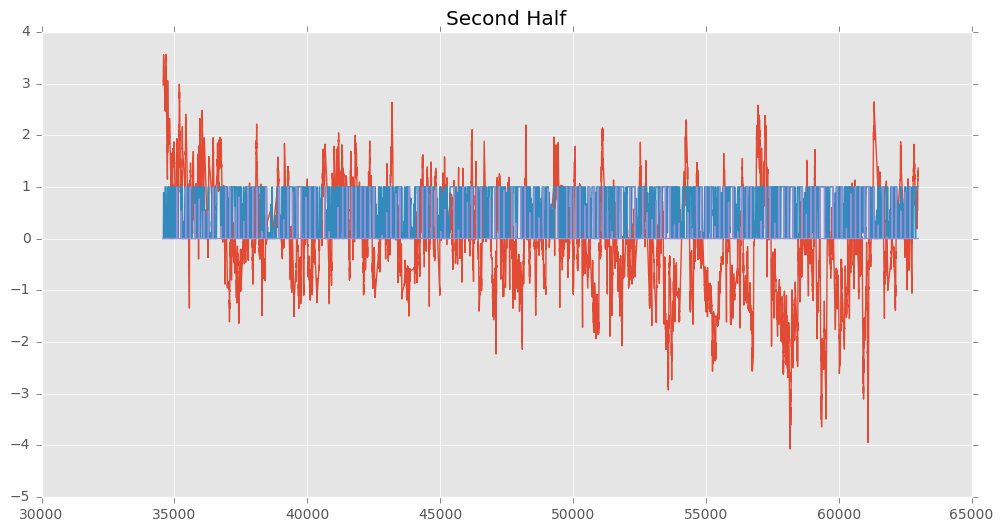

In [43]:
if view_graph:
    psize_df['trialQuality'] = 0
    for idx, trialQuality in zip(stim_indices, trial_df['qualityPsize'].tolist()):
        psize_df.loc[idx-3, 'trialQuality'] = trialQuality
    
    plt.figure(figsize=(12, 6))
    plt.plot(psize_df.loc[:break_start_idx, ['zPsize', quality_col, 'trialQuality']])
    plt.title('First Half')
    
    plt.figure(figsize=(12, 6))
    plt.plot(psize_df.loc[break_end_idx:, ['zPsize', quality_col, 'trialQuality']])
    plt.title('Second Half')
    
print(bordered('Red: zPsize, Blue: sample quality, Purple: stimulus onset (height equals the trial quality)'))

In [44]:
# If you want to view an interactive versin of the eye data, change the variable view_interactive_plot to True
# NOTE: the lab has a free account with this software, so you can only plot 50 or so a day before you are cut off.
view_interactive_plot = True

tempPlot = 'view_interactive_plot is False. Set to True to view interactive graph...'
if view_interactive_plot:
    tempPlot = psize_df.loc[:, ['zPsize', quality_col, 'trialQuality']].iplot(subplots=False, shared_xaxes=True, fill=False, filename='Participant %d%s: Psize Processing Preview' % (participant_num, sart_sequence))
tempPlot

C:\Users\ewamsley\AppData\Local\Continuum\Anaconda3\lib\site-packages\plotly\plotly\plotly.py:236: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



The draw time for this plot will be slow for all clients.


C:\Users\ewamsley\AppData\Local\Continuum\Anaconda3\lib\site-packages\plotly\plotly\plotly.py:1443: UserWarning:

Estimated Draw Time Too Long



## Inclusion/Exclusion Info

In [45]:
# This prints out what percentage of the trials have less than 20% of their samples interpolated (80% original data)
number_of_trials = trial_df.shape[0]
number_good_trials = trial_df.loc[trial_df['qualityPsize'] >= .8,].shape[0]

print(bordered('Percent of usable trials at .8 threshold: \n  ' + str(number_good_trials/number_of_trials)))

┌──────────────────────────────────────────┐
│Percent of usable trials at .8 threshold: │
│  0.6419753086419753                      │
└──────────────────────────────────────────┘


# Export

In [46]:
if export:
    trial_df.to_csv(path_or_buf=participant_path + '/%(pNum)02d%(seq)sSARTPupilProcessed.csv' % pathdict)